# Upload Survival Model to MLflow

@roman_avj

7 nov 2023


In [2]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import boto3
import sqlalchemy
import mlflow
import cloudpickle


from sksurv.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold

from xgbse import XGBSEStackedWeibull
from xgbse.extrapolation import extrapolate_constant_risk
import lifelines

from scipy.integrate import simpson
from scipy.optimize import brentq

import geopandas as gpd
import folium

from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)
from xgbse.metrics import (
    approx_brier_score,
    dist_calibration_score,
    concordance_index
)

# Data

## Read & Clean

In [3]:
# read
df_model = pd.read_parquet('../../data/data2analyze_clean_v2.parquet')
df_model.info()

# add if has maintenance
df_model['has_maintenance'] = df_model['cost_of_maintenance'].apply(lambda x: 1 if x > 0 else 0)

# clip columns with 'lag' up to 99 percentile
vars_lag = df_model.columns[df_model.columns.str.contains('lag')]
df_model[vars_lag] = df_model[vars_lag].clip(upper=df_model[vars_lag].quantile(0.99), axis=1)

# look rows with maximum time2event
df_max = df_model[df_model['time2event'] == df_model['time2event'].max()]

[FATAL] 2023-11-10 18:18:23.145 Aws::Config::ConfigFileProfileFSM [0x202632280] Unknown parser error: unexpected state 4
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73938 entries, 0 to 73937
Columns: 141 entries, id to cosine_tmonth
dtypes: datetime64[us](2), float64(122), int32(1), int64(4), object(9), string(3)
memory usage: 79.3+ MB


## Transformations

In [27]:
print(vars_x_names)

['listing_type', 'property_type', 'first_price', 'diff_first_prediction', 'prediction_price_per_square_meter', 'surface_total', 'page_on_marketplace', 'is_new_property_prob', 'total_cost_of_living', 'days_active', 'relative_cost_of_living', 'is_exterior', 'has_gym', 'pets_allowed', 'has_maintenance', 'num_bedrooms', 'latitude', 'longitude', 'woe_marketplace', 'woe_seller', 'woe_id_sepomex', 'sine_tmonth', 'cosine_tmonth']


In [4]:
# select columns
vars_x_categorical = ['listing_type', 'property_type']
vars_x_discrete = ['num_bedrooms']
vars_x_woe = ['woe_marketplace', 'woe_seller', 'woe_id_sepomex']
vars_x_numerical = [
    'first_price', 'diff_first_prediction', 
    'prediction_price_per_square_meter',
    'surface_total', 'page_on_marketplace',
    'is_new_property_prob', 'total_cost_of_living', 'days_active', 'relative_cost_of_living']
vars_x_binary = ['is_exterior', 'has_gym', 'pets_allowed', 'has_maintenance']
vars_x_geographic = ['latitude', 'longitude']
vars_x_time = ['sine_tmonth', 'cosine_tmonth']

vars_x_names = vars_x_categorical + vars_x_numerical + vars_x_binary + vars_x_discrete + vars_x_geographic + vars_x_woe + vars_x_time
vars_x_names_id = vars_x_names

# get y data as sksurv need
data_y = np.array(
    list(zip(df_model['event'], df_model['time2event'])),
    dtype=[('Status', '?'), ('Survival_in_days', '<f8')]
)

# get x data
data_x = (
    df_model.copy()
    .astype({col: 'category' for col in vars_x_categorical})
    .astype({col: np.float64 for col in vars_x_numerical + vars_x_discrete + vars_x_binary + vars_x_geographic + vars_x_woe + vars_x_time})
    .astype({col: np.int8 for col in vars_x_binary})
    [vars_x_names]
)
data_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73938 entries, 0 to 73937
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   listing_type                       73938 non-null  category
 1   property_type                      73938 non-null  category
 2   first_price                        73938 non-null  float64 
 3   diff_first_prediction              73938 non-null  float64 
 4   prediction_price_per_square_meter  73938 non-null  float64 
 5   surface_total                      73938 non-null  float64 
 6   page_on_marketplace                73938 non-null  float64 
 7   is_new_property_prob               73938 non-null  float64 
 8   total_cost_of_living               73938 non-null  float64 
 9   days_active                        73938 non-null  float64 
 10  relative_cost_of_living            73938 non-null  float64 
 11  is_exterior                        73938 

In [5]:
data_x.loc[0]

listing_type                             for-rent
property_type                           apartment
first_price                                8900.0
diff_first_prediction                   -0.097642
prediction_price_per_square_meter      142.942667
surface_total                                69.0
page_on_marketplace                           2.0
is_new_property_prob                       0.5044
total_cost_of_living                 25043.204753
days_active                             24.530747
relative_cost_of_living                178.435238
is_exterior                                     0
has_gym                                         0
pets_allowed                                    1
has_maintenance                                 0
num_bedrooms                                  2.0
latitude                                19.478474
longitude                              -99.210293
woe_marketplace                          0.290533
woe_seller                               0.068438


In [6]:
vars_x_numerical

['first_price',
 'diff_first_prediction',
 'prediction_price_per_square_meter',
 'surface_total',
 'page_on_marketplace',
 'is_new_property_prob',
 'total_cost_of_living',
 'days_active',
 'relative_cost_of_living']

In [7]:
# one hot encoding
data_x_numeric = OneHotEncoder().fit_transform(data_x)

colnames_x_numeric = data_x_numeric.columns
data_x_numeric = data_x_numeric.to_numpy()

# boxcox
location_cols_boxcox = [colnames_x_numeric.get_loc(col) for col in vars_x_numerical]

data_x_numeric_aux_boxcox = data_x_numeric[:, location_cols_boxcox]
power_transform = PowerTransformer(method='yeo-johnson', standardize=True).fit(data_x_numeric_aux_boxcox)
data_x_numeric_aux_boxcox = power_transform.transform(data_x_numeric_aux_boxcox)
data_x_numeric[:,location_cols_boxcox] = data_x_numeric_aux_boxcox

# scale
location_cols_scale = [colnames_x_numeric.get_loc(col) for col in vars_x_discrete + vars_x_geographic]
data_x_numeric_aux_scale = data_x_numeric[:, location_cols_scale]
standard_scaler = StandardScaler().fit(data_x_numeric_aux_scale)
data_x_numeric_aux_scale = standard_scaler.transform(data_x_numeric_aux_scale)
data_x_numeric[:,location_cols_scale] = data_x_numeric_aux_scale

In [8]:
colnames_x_numeric

Index(['listing_type=for-sale', 'property_type=house', 'first_price',
       'diff_first_prediction', 'prediction_price_per_square_meter',
       'surface_total', 'page_on_marketplace', 'is_new_property_prob',
       'total_cost_of_living', 'days_active', 'relative_cost_of_living',
       'is_exterior', 'has_gym', 'pets_allowed', 'has_maintenance',
       'num_bedrooms', 'latitude', 'longitude', 'woe_marketplace',
       'woe_seller', 'woe_id_sepomex', 'sine_tmonth', 'cosine_tmonth'],
      dtype='object')

## Check Box Cox Inverse

In [9]:
# look transformed data is the same as original
data_aux = data_x[vars_x_numerical].copy()
(pd.DataFrame(power_transform.inverse_transform(data_x_numeric_aux_boxcox), columns=vars_x_numerical) - data_aux).describe()

,first_price,diff_first_prediction,prediction_price_per_square_meter,surface_total,page_on_marketplace,is_new_property_prob,total_cost_of_living,days_active,relative_cost_of_living
count,7.393800e+04,7.393800e+04,7.393800e+04,7.393800e+04,7.393800e+04,7.393800e+04,7.393800e+04,7.393800e+04,7.393800e+04
mean,-7.297361e-10,-4.046703e-18,1.125902e-11,4.403884e-14,2.671160e-15,-1.223367e-17,-1.965533e-11,1.085877e-14,-2.693716e-14
std,3.513664e-09,7.437877e-16,1.373339e-11,5.240604e-13,1.392541e-13,9.654644e-17,1.038077e-10,1.144680e-14,3.594257e-13
min,-2.421439e-08,-5.329071e-15,-2.910383e-11,-9.777068e-12,-1.864464e-11,-3.330669e-16,-7.130438e-10,-1.065814e-14,-9.094947e-13
25%,-9.313226e-10,-2.220446e-16,5.684342e-14,-2.131628e-14,0.000000e+00,-5.551115e-17,-5.820766e-11,0.000000e+00,-3.126388e-13
50%,-5.456968e-12,0.000000e+00,7.275958e-12,2.842171e-14,0.000000e+00,0.000000e+00,-7.275958e-12,1.065814e-14,-2.842171e-14
75%,7.275958e-12,2.220446e-16,2.182787e-11,7.105427e-14,1.776357e-15,5.551115e-17,2.546585e-11,2.131628e-14,2.557954e-13
max,2.048910e-08,5.329071e-15,1.164153e-10,1.159606e-11,4.547474e-12,3.330669e-16,4.802132e-10,5.684342e-14,8.526513e-13


array([[<Axes: title={'center': 'first_price'}>,
        <Axes: title={'center': 'diff_first_prediction'}>,
        <Axes: title={'center': 'prediction_price_per_square_meter'}>],
       [<Axes: title={'center': 'surface_total'}>,
        <Axes: title={'center': 'page_on_marketplace'}>,
        <Axes: title={'center': 'is_new_property_prob'}>],
       [<Axes: title={'center': 'total_cost_of_living'}>,
        <Axes: title={'center': 'days_active'}>,
        <Axes: title={'center': 'relative_cost_of_living'}>]],
      dtype=object)

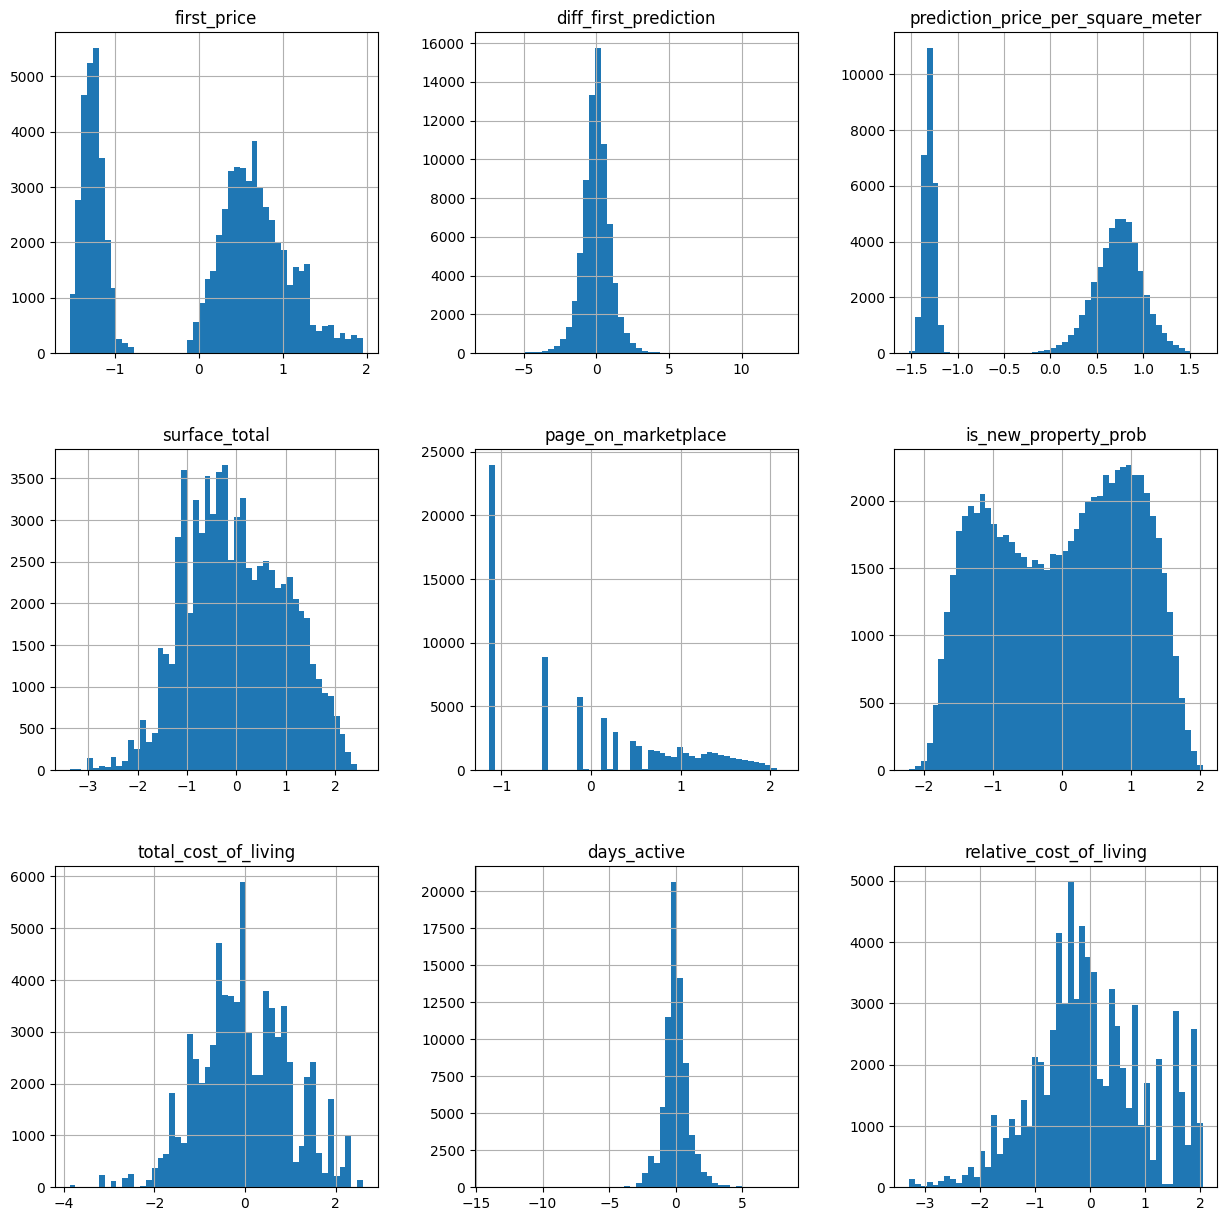

In [10]:
pd.DataFrame(data_x_numeric_aux_boxcox, columns=vars_x_numerical).hist(layout=(3,3), figsize=(15,15), bins=50)

# Fit Model

In [11]:
# split train & test
X_train, X_test, y_train, y_test = train_test_split(
    data_x_numeric, data_y, test_size=0.1, random_state=42, shuffle=True
)

In [12]:
# print shapes
print(X_train.shape)
print(X_test.shape)

(66544, 23)
(7394, 23)


In [13]:
# fit weibull
xgbse_weibull = XGBSEStackedWeibull() # use vanilla method, has performed better
y_max = y_train['Survival_in_days'].max().astype(int)

xgbse_weibull.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    early_stopping_rounds=50,
    verbose_eval=50,
    time_bins = range(1, y_max, 1)
)

[0]	validation-aft-nloglik:13.01941
[50]	validation-aft-nloglik:3.45500
[100]	validation-aft-nloglik:3.37323
[150]	validation-aft-nloglik:3.37041
[200]	validation-aft-nloglik:3.37010
[250]	validation-aft-nloglik:3.37011
[279]	validation-aft-nloglik:3.37001


XGBSEStackedWeibull(weibull_params={},
                    xgb_params={'aft_loss_distribution': 'normal',
                                'aft_loss_distribution_scale': 1,
                                'booster': 'dart', 'colsample_bynode': 0.5,
                                'eval_metric': 'aft-nloglik',
                                'learning_rate': 0.05, 'max_depth': 8,
                                'min_child_weight': 50,
                                'objective': 'survival:aft', 'subsample': 0.5,
                                'tree_method': 'hist'})

In [14]:
def get_xgbse_mean_time(df):
    """Get mean time to event for a given time interval."""
    # get linespace from names of columns
    delta = df.columns.astype(int).to_numpy()
    # get survival probabilities as the values of the dataframe
    surv_probas = df.values

    # for each row, compute the area under the curve
    mean_time = np.array([simpson(y=y, x=delta) for y in surv_probas])

    return(mean_time)

def get_metrics(df):
    df = df.copy()
    cindex = concordance_index_censored(df['event'], df['observed_time'], df['risk_score'])[0]
    # rmse & mape for all with event as True
    rmse = np.sqrt(np.mean((df[df['event']]['predicted_time'] - df[df['event']]['observed_time'])**2))
    return pd.Series({'rmse': rmse, 'cindex': cindex})

def get_prediction_df(X, y, colnames, model):
    # get rmse, mape and cindex by listing & property type
    df_pred = (
        pd.DataFrame(X, columns=colnames)
        .assign(
            observed_time=y['Survival_in_days'],
            event=y['Status'],
            predicted_time=model.predict(X).pipe(get_xgbse_mean_time),
            risk_score=lambda x: - x['predicted_time']
        )
        .rename(columns={
        'listing_type=for-sale': 'listing_type',
        'property_type=house': 'property_type',
        })
        .assign(
            listing_type=lambda x: np.where(x['listing_type'] == 1, 'for-sale', 'for-rent'),
            property_type=lambda x: np.where(x['property_type'] == 1, 'house', 'apartment'),
        )  
    )

    return df_pred

# get prediction df
df_pred = get_prediction_df(X_test, y_test, colnames_x_numeric, xgbse_weibull)

# get metrics
table_metrics = (
    df_pred
    .groupby(['listing_type', 'property_type'])
    .apply(get_metrics)
)
table_metrics

rmse    cindex
listing_type property_type                     
for-rent     apartment      24.745525  0.658456
             house          29.560132  0.636340
for-sale     apartment      43.316285  0.720126
             house          43.607878  0.694683

# Upload to MLflow

## Setup

In [75]:
# keys
os.environ["AWS_PROFILE"] = "default" # prod

# track server
TRACKING_SERVER_HOST = "mlflow.prod.dd360.mx" # fill in with the public DNS of the EC2 instance

# set uri
mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:443")

# experiment
EXPERIMENT_NAME = "liquidity-cdmx"
mlflow.set_experiment(EXPERIMENT_NAME)

<Experiment: artifact_location='s3://dd360-ds-artifacts/134', creation_time=1699546350370, experiment_id='134', last_update_time=1699546350370, lifecycle_stage='active', name='liquidity-cdmx', tags={}>

## Start Run

In [104]:
# cloudpickle
power_transform_serialized = cloudpickle.dumps(power_transform)
standard_scaler_serialized = cloudpickle.dumps(standard_scaler)
xgbse_weibull_serialized = cloudpickle.dumps(xgbse_weibull)

In [140]:
# # start run
# with mlflow.start_run() as run:
#     # set tags
#     mlflow.set_tag('model', 'survival')
#     mlflow.set_tag('model-type', 'xgbse-stacked-weibull')
#     mlflow.set_tag('model-name', 'liquidity_v1')
#     mlflow.set_tag('model-version', '1.0.0')
#     mlflow.set_tag('model-description', 'Modelo de supervivencia para predecir el tiempo de venta de una propiedad')
#     # log model

#     # mlflow.log_artifact(xgbse_weibull, 'model')
#     # log variables
#     mlflow.log_param('variables', vars_x_names)
#     mlflow.log_param('categorical_variables', vars_x_categorical)
#     mlflow.log_param('discrete_variables', vars_x_discrete)
#     mlflow.log_param('woe_variables', vars_x_woe)
#     mlflow.log_param('numerical_variables', vars_x_numerical)
#     mlflow.log_param('binary_variables', vars_x_binary)
#     mlflow.log_param('geographic_variables', vars_x_geographic)
#     mlflow.log_param('time_variables', vars_x_time)
#     # log transformations
#     mlflow.sklearn.log_model(power_transform_serialized, 'power_transform', serialization_format=mlflow.sklearn.SERIALIZATION_FORMAT_CLOUDPICKLE)
#     mlflow.sklearn.log_model(standard_scaler_serialized, 'standard_scaler', serialization_format=mlflow.sklearn.SERIALIZATION_FORMAT_CLOUDPICKLE)
#     mlflow.sklearn.log_model(xgbse_weibull_serialized, 'xgbse_weibull', serialization_format=mlflow.sklearn.SERIALIZATION_FORMAT_CLOUDPICKLE)
#     # log all the table_metrics
#     for index, row in table_metrics.iterrows():
#         mlflow.log_metric(f"rmse_{index[0]}_{index[1]}", row['rmse'])
#         mlflow.log_metric(f"cindex_{index[0]}_{index[1]}", row['cindex'])
    
# # end run
# mlflow.end_run()

2023/11/09 16:28:59 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
/Users/ravj/opt/anaconda3/envs/dd3surv/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/ravj/opt/anaconda3/envs/dd3surv/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2023/11/09 16:29:03 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/09 16:29:05 WARNING mlflow.sklearn: Mode

## Try to load model

In [137]:
# # get log id
# log_id = "39d3eadaedf5499d9051fdfa94bd6994"

# # load models #
# # load power transform
# power_transform_load = cloudpickle.loads(mlflow.sklearn.load_model(f"runs:/{log_id}/power_transform"))
# # load standard scaler
# standard_scaler_load = cloudpickle.loads(mlflow.sklearn.load_model(f"runs:/{log_id}/standard_scaler"))
# # # load xgbse weibull
# xgbse_weibull_load =  cloudpickle.loads(mlflow.sklearn.load_model(f"runs:/{log_id}/xgbse_weibull"))

### Check

In [124]:
# # look transformed data is the same as original
# data_aux = data_x[vars_x_discrete + vars_x_geographic].copy()
# (pd.DataFrame(standard_scaler_load.inverse_transform(data_x_numeric_aux_scale), columns=location_cols_scale) - pd.DataFrame(standard_scaler_load.inverse_transform(data_x_numeric_aux_scale), columns=location_cols_scale)).describe()

,15,16,17
count,73938.0,73938.0,73938.0
mean,0.0,0.0,0.0
std,0.0,0.0,0.0
min,0.0,0.0,0.0
25%,0.0,0.0,0.0
50%,0.0,0.0,0.0
75%,0.0,0.0,0.0
max,0.0,0.0,0.0


In [126]:
# xgbse_weibull_load

XGBSEStackedWeibull(weibull_params={},
                    xgb_params={'aft_loss_distribution': 'normal',
                                'aft_loss_distribution_scale': 1,
                                'booster': 'dart', 'colsample_bynode': 0.5,
                                'eval_metric': 'aft-nloglik',
                                'learning_rate': 0.05, 'max_depth': 8,
                                'min_child_weight': 50,
                                'objective': 'survival:aft', 'subsample': 0.5,
                                'tree_method': 'hist'})

In [136]:
# get one value
data_x.loc[0]

listing_type                             for-rent
property_type                           apartment
first_price                                8900.0
diff_first_prediction                   -0.097642
prediction_price_per_square_meter      142.942667
surface_total                                69.0
page_on_marketplace                           2.0
is_new_property_prob                       0.5044
total_cost_of_living                 25043.204753
days_active                             24.530747
relative_cost_of_living                178.435238
is_exterior                                     0
has_gym                                         0
pets_allowed                                    1
has_maintenance                                 0
num_bedrooms                                  2.0
latitude                                19.478474
longitude                              -99.210293
woe_marketplace                          0.290533
woe_seller                               0.068438


In [139]:
# def load_models(log_id):
#     """
#     Load models from mlflow
#     """
#     # get the model

#     # load power transform
#     power_transform_load = cloudpickle.loads(mlflow.sklearn.load_model(f"runs:/{log_id}/power_transform"))
#     # load standard scaler
#     standard_scaler_load = cloudpickle.loads(mlflow.sklearn.load_model(f"runs:/{log_id}/standard_scaler"))
#     # # load xgbse weibull
#     xgbse_weibull_load =  cloudpickle.loads(mlflow.sklearn.load_model(f"runs:/{log_id}/xgbse_weibull"))

#     # save them into a dictionary
#     models = {
#         "power_transform": power_transform_load,
#         "standard_scaler": standard_scaler_load,
#         "xgbse_weibull": xgbse_weibull_load
#     }
#     return models

# LOG_ID = "39d3eadaedf5499d9051fdfa94bd6994"
# models = load_models(LOG_ID)


# Save Model 

In [23]:
# create directory
os.makedirs('models', exist_ok=True)

In [24]:
# save to cloudpickle
with open('models/power_transform.pkl', 'wb') as f:
    cloudpickle.dump(power_transform, f)

with open('models/standard_scaler.pkl', 'wb') as f:
    cloudpickle.dump(standard_scaler, f)

with open('models/xgbse_weibull.pkl', 'wb') as f:
    cloudpickle.dump(xgbse_weibull, f)
    

In [25]:
# load from cloudpickle
with open('models/power_transform.pkl', 'rb') as f:
    power_transform_load = cloudpickle.load(f)

with open('models/standard_scaler.pkl', 'rb') as f:
    standard_scaler_load = cloudpickle.load(f)

with open('models/xgbse_weibull.pkl', 'rb') as f:
    xgbse_weibull_load = cloudpickle.load(f)
    

## Compare

In [20]:
xgbse_weibull_load.predict(data_x_numeric[0:1])

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,168.0,169.0,170.0,171.0,172.0,173.0,174.0,175.0,176.0,177.0
0,0.996792,0.990434,0.981918,0.971655,0.959907,0.946875,0.932718,0.917573,0.901559,0.884784,...,0.000025,0.000023,0.000021,0.000019,0.000017,0.000015,0.000014,0.000012,0.000011,0.00001


In [21]:
xgbse_weibull.predict(data_x_numeric[0:1])

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,168.0,169.0,170.0,171.0,172.0,173.0,174.0,175.0,176.0,177.0
0,0.996792,0.990434,0.981918,0.971655,0.959907,0.946875,0.932718,0.917573,0.901559,0.884784,...,0.000025,0.000023,0.000021,0.000019,0.000017,0.000015,0.000014,0.000012,0.000011,0.00001


# Sandbox

In [142]:
X_test[0]

array([ 1.00000000e+00,  0.00000000e+00,  4.98845555e-01,  7.07363071e-01,
        7.85061777e-01, -6.38278935e-01,  3.01127414e-01,  1.42833253e+00,
       -3.81594977e-01,  1.00374141e+00, -5.11027259e-03,  0.00000000e+00,
        0.00000000e+00,  1.00000000e+00,  0.00000000e+00, -5.26373085e-01,
       -1.59869540e+00,  1.31350246e+00,  2.90532970e-01, -1.12035485e+00,
        2.71256568e-01, -1.00000000e+00, -1.83697020e-16])

In [143]:
pd.DataFrame(X_test, columns=colnames_x_numeric).loc[0]

listing_type=for-sale                1.000000e+00
property_type=house                  0.000000e+00
first_price                          4.988456e-01
diff_first_prediction                7.073631e-01
prediction_price_per_square_meter    7.850618e-01
surface_total                       -6.382789e-01
page_on_marketplace                  3.011274e-01
is_new_property_prob                 1.428333e+00
total_cost_of_living                -3.815950e-01
days_active                          1.003741e+00
relative_cost_of_living             -5.110273e-03
is_exterior                          0.000000e+00
has_gym                              0.000000e+00
pets_allowed                         1.000000e+00
has_maintenance                      0.000000e+00
num_bedrooms                        -5.263731e-01
latitude                            -1.598695e+00
longitude                            1.313502e+00
woe_marketplace                      2.905330e-01
woe_seller                          -1.120355e+00


In [30]:
cloudpickle.load(open("models/xgbse_weibull.pkl", "rb"))

XGBSEStackedWeibull(weibull_params={},
                    xgb_params={'aft_loss_distribution': 'normal',
                                'aft_loss_distribution_scale': 1,
                                'booster': 'dart', 'colsample_bynode': 0.5,
                                'eval_metric': 'aft-nloglik',
                                'learning_rate': 0.05, 'max_depth': 8,
                                'min_child_weight': 50,
                                'objective': 'survival:aft', 'subsample': 0.5,
                                'tree_method': 'hist'})